In [1]:
from pathlib import Path
import pickle
from models import CTCNet
from utils import create_data_loaders
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_path = "/Users/patmccarthy/Documents/thalamocortex/results/ff_06_02_24"

In [3]:
# learning progress
with open(Path(f"{results_path}", "learning.pkl"), "rb") as handle:
    learning = pickle.load(handle)

In [4]:
# hyperparams
with open(Path(f"{results_path}", "hyperparams.pkl"), "rb") as handle:
    hyperparams = pickle.load(handle)

In [5]:
# model
model = CTCNet(input_size=hyperparams["input_size"],
                output_size=hyperparams["output_size"],
                ctx_layer_size=hyperparams["ctx_layer_size"],
                thal_layer_size=hyperparams["thal_layer_size"],
                thalamocortical_type=hyperparams["thalamocortical_type"],
                thal_reciprocal=hyperparams["thal_reciprocal"],
                thal_to_readout=hyperparams["thal_to_readout"], 
                thal_per_layer=hyperparams["thal_per_layer"])
model_weights = torch.load(Path(f"{results_path}", "model.pth"))
model.load_state_dict(model_weights)

<All keys matched successfully>

Plot learning curve

In [6]:
train_losses = np.array(learning["train_losses"])
train_losses_flat = train_losses.flatten(order="C")
val_losses = np.array(learning["val_losses"])
val_losses_flat = val_losses.flatten(order="C")
val_losses_flat.shape
train_losses_flat.shape
train_losses_ax = np.arange(0, len(train_losses_flat))
val_losses_ax = np.arange(0, len(train_losses_flat), len(train_losses_flat)/len(val_losses_flat))

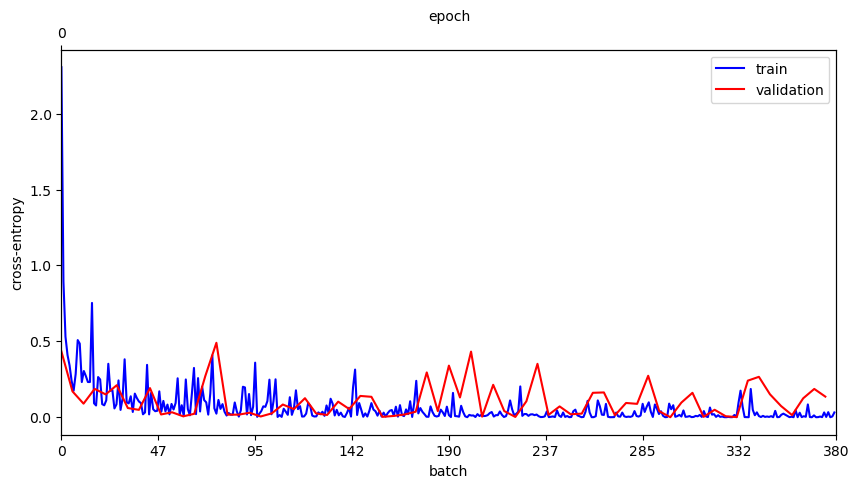

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.plot(train_losses_ax, train_losses_flat, c="b", label="train")
ax1.plot(val_losses_ax, val_losses_flat, c="r", label="validation")
# ax.set_ylim(0, 1)
ax1.set_xlim(0, len(train_losses_flat))
ax1.set_ylabel("cross-entropy")
ax1.set_xlabel("batch")
x_tick_locs = np.linspace(0, len(train_losses_flat), 9)
ax1.set_xticks(x_tick_locs)
ax1.set_xticklabels(x_tick_locs.astype(int), size=10)
ax2 = ax1.twiny()
new_tick_step = 20
new_tick_locs = np.arange(0, len(train_losses_flat)+ 1, (new_tick_step * len(train_losses_flat))// train_losses.shape[0])
ax2.set_xticks(new_tick_locs)
ax2.set_xticklabels(np.arange(0, train_losses.shape[0]+1, new_tick_step), size=10)
ax2.set_xlabel("epoch")
ax1.legend()

Test on sample image

In [8]:
# load data
traiset_loader, testset_loader, metadata = create_data_loaders(dataset=hyperparams["dataset"],
                                                               norm=hyperparams["norm"],
                                                               batch_size=hyperparams["batch_size"],
                                                               save_path=hyperparams["save_path"])

In [9]:
# get batch
X, y = next(iter(testset_loader))

In [34]:
# select image and load
img_idx = 5
X_i  = X[img_idx, :, :, :]
y_i = y[img_idx].detach().numpy()

In [35]:
# inference
y_est_logits = model(X_i).detach().numpy()
y_est_prob = softmax(y_est_logits)
y_est = np.argmax(y_est_prob)

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_3361/3629363834.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


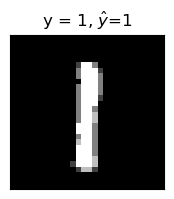

In [36]:
# plot image
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(X_i[0, ], cmap="gray")
ax.set_title(f"y = {y_i}, $\hat{{y}}$={y_est}")
ax.set_xticks([])
ax.set_yticks([])
fig.show()

In [38]:
np.mean(learning["final_val_losses"])

0.037805134480419965